<a href="https://colab.research.google.com/github/HyeJiJUN11/DataAnalysisProgramming/blob/main/Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#한글 폰트 적용
#한글 깨짐 현상 수정 -> https://teddylee777.github.io/colab/colab-korean

!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following NEW packages will be installed:
  fonts-nanum
0 upgraded, 1 newly installed, 0 to remove and 37 not upgraded.
Need to get 9,604 kB of archives.
After this operation, 29.5 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 fonts-nanum all 20170925-1 [9,604 kB]
Fetched 9,604 kB in 3s (3,192 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 76, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected package fonts-nanum.
(Reading database ... 155222 files and d

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
plt.rc('font', family='NanumBarunGothic') 
import datetime

In [19]:
# install packages
!pip install dash
!pip install jupyter_dash

     |████████████████████████████████| 7.3 MB 4.1 MB/s 
     |████████████████████████████████| 25.3 MB 1.7 MB/s 
     |████████████████████████████████| 357 kB 38.7 MB/s 
  Created wheel for dash-core-components: filename=dash_core_components-2.0.0-py3-none-any.whl size=3821 sha256=281ff10de4b9f51b30d15bba139d8f3d6488033b32a64dc578e8c84c5ff26778
  Stored in directory: /root/.cache/pip/wheels/00/f9/c7/1a6437d794ed753ea9bc9079e761d4fc803a1f1f5d3697b9ec
  Created wheel for dash-html-components: filename=dash_html_components-2.0.0-py3-none-any.whl size=4089 sha256=5a3c37a386236c99d4fd5559215d065919599d4ff5bf9feaaf11fd47f6282f12
  Stored in directory: /root/.cache/pip/wheels/ec/6b/81/05aceabd8b27f724e2c96784016287cc1bfbc349ebfda451de
  Created wheel for dash-table: filename=dash_table-5.0.0-py3-none-any.whl size=3911 sha256=c22fc9aa67d4340b645994836a61abc9ac262a499dca70a58022a9379e840722
  Stored in directory: /root/.cache/pip/wheels/85/5d/4e/7c276b57992951dbe770bf5caad6448d0539c510663aef

# **Project**
202013340 전혜지


## 데이터 불러오기

In [31]:
#데이터 받아오고, 처음 5row 출력
df = pd.read_csv('/content/서울시 노원구 식품위생업소 행정처분내역 현황.csv', encoding='euc-kr', parse_dates=['처분일자']);
df.head()

,시군구코드,처분일자,교부번호,업종명,업태명,업소명,소재지도로명,소재지지번,지도점검일자,행정처분상태,처분명,위반내역분류,법적근거,위반일자,위반내용,처분내용,처분기간,적발구분,신고구분,적발기관명(적발기관),외부적발접수일자,영업장면적(㎡),운영형태
0,3100000,2004-09-14,19990060386,일반음식점,호프/통닭,원샷,NaN,서울특별시 노원구 공릉동 411번지 18호 지하1층,20040710,처분확정,영업정지2월,NaN,식품위생법제31조,20040710,청소년주류제공1차,영업정지2월,NaN,기타,2,NaN,20040719,62.32,NaN
1,3100000,2005-09-23,18990059004,일반음식점,분식,동호,NaN,서울특별시 노원구 상계동 651번지 0호 109 11단지종합상가,20050816,처분확정,영업정지 7일갈음 과징금 84만원,NaN,식품위생법 제65조,20050816,영업장면적 무단변경,영업정지 7일갈음 과징금 84만원,7.0,수시,,NaN,,18.42,NaN
2,3100000,2007-08-20,18990059004,일반음식점,분식,동호,NaN,서울특별시 노원구 상계동 651번지 0호 109 11단지종합상가,20070725,처분확정,시정명령,NaN,식품위생법 제21조,20070725,영업장외영업,시정명령,NaN,기타,,NaN,,18.42,NaN
3,3100000,2007-10-18,18990059004,일반음식점,분식,동호,NaN,서울특별시 노원구 상계동 651번지 0호 109 11단지종합상가,20070831,처분확정,과징금부과(56만원),NaN,식품위생법 제21조,20070831,영업장외 영업(탁자),과징금부과(56만원),7.0,수시,,NaN,,18.42,NaN
4,3100000,2005-10-24,19770059003,일반음식점,분식,천궁,NaN,서울특별시 노원구 월계동 272번지 31호,20051011,처분확정,시정명령,NaN,식품위생법 제55조,20051011,이물혼입,시정명령,NaN,수시,,NaN,,110.30,NaN


In [32]:
#데이터 사이즈 확인
print('rowXcol')
print(len(df), 'X', len(df.columns))

#날짜 확인
print('\n')
print('가장 오래된 날짜 : ',df['위반일자'].min())
print('가장 최근 날짜 : ',df['위반일자'].max())

rowXcol
5636 X 23


가장 오래된 날짜 :  19940301
가장 최근 날짜 :  20211026


쓰지 않을 colnums 제거.
2000년부터 2020년 까지 분석을 위해 'Year' column 만들고,

In [33]:
#쓰지 않을 colnums 제거
df = df.drop(['교부번호', '소재지지번', '소재지도로명', '지도점검일자', '행정처분상태', '위반일자', '법적근거', '처분내용', '위반내역분류', '처분기간', '운영형태', '외부적발접수일자', '적발기관명(적발기관)', '영업장면적(㎡)', '신고구분'], axis=1)

#Year로 년도만 가져오고, 2000~2020외 row삭제
df['Year'] = df['처분일자'].dt.year 
df = df[(df.Year >= 2000) & (df.Year<2021)]
df.head()

,시군구코드,처분일자,업종명,업태명,업소명,처분명,위반내용,적발구분,Year
0,3100000,2004-09-14,일반음식점,호프/통닭,원샷,영업정지2월,청소년주류제공1차,기타,2004
1,3100000,2005-09-23,일반음식점,분식,동호,영업정지 7일갈음 과징금 84만원,영업장면적 무단변경,수시,2005
2,3100000,2007-08-20,일반음식점,분식,동호,시정명령,영업장외영업,기타,2007
3,3100000,2007-10-18,일반음식점,분식,동호,과징금부과(56만원),영업장외 영업(탁자),수시,2007
4,3100000,2005-10-24,일반음식점,분식,천궁,시정명령,이물혼입,수시,2005


업종별로 분류, 일반음식점이 다른 업종에 비해 극단적으로 많음으로 일반음식점만 따로 분석.

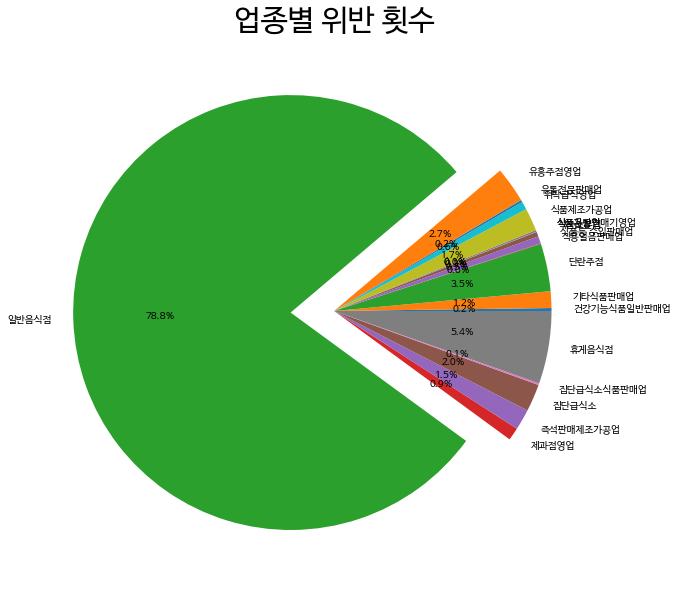

In [35]:
#업종별 pie chart
df_count = df.groupby(by=['업종명'], as_index=False).count()
frequency = df_count['Year'];
label = df_count['업종명'];

plt.title('업종별 위반 횟수', size=30)
plt.rcParams["figure.figsize"] = (15, 15)
lst = np.zeros(len(df_count))
lst[12] = 0.2
plt.pie(frequency, labels=label, autopct='%.1f%%', explode=lst)
plt.show()

In [ ]:
#업종별 bar plot
plt.rcParams["figure.figsize"] = (25, 5)
plt.rc('font', family='NanumBarunGothic') 
fig = sns.countplot(x ='업종명', data = df, order = df['업종명'].value_counts().index)

### 일반음식점 제외한 업종 분석

In [ ]:
#일반음식점을 제외한 데이터 받아옴
dfDropRegular = df[df.업종명 !='일반음식점']
dfDropRegular.head()

,시군구코드,처분일자,업종명,업태명,업소명,처분명,위반내용,적발구분,Year
2185,3100000,2002-05-01,유흥주점영업,간이주점,보스,시정명령(2002.05.15까지),종업원명부미기재,기타,2002
2186,3100000,2010-03-02,유흥주점영업,간이주점,포차 멜로디 노래타운,과태료 20만원 부과,영업자 위생교육 미필,기타,2010
2187,3100000,2004-06-23,유흥주점영업,룸살롱,무랑루즈비즈니스,시정명령,업종 미표시,합동,2004
2188,3100000,2018-01-08,유흥주점영업,룸살롱,마이웨이,시정명령,이물이 혼입된 경우(플라스틱 병뚜껑),수시,2018
2189,3100000,2002-02-01,유흥주점영업,룸살롱,24시유흥주점,영업정지15일(2002.02.05-02.19),유통기한경과제품조리판매목적보관,기타,2002


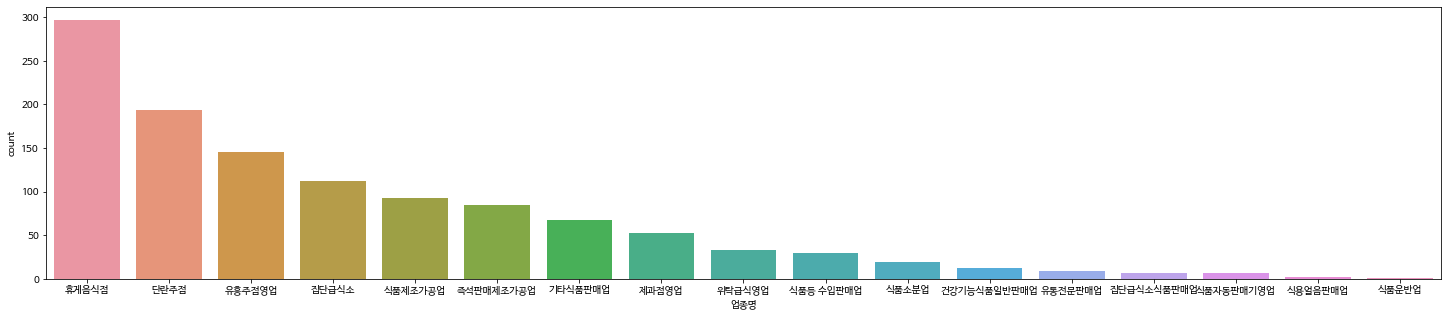

In [ ]:
plt.rcParams["figure.figsize"] = (25, 5)
fig = sns.countplot(x ='업종명', data = dfDropRegular, order = dfDropRegular['업종명'].value_counts().index)

### 일반음식점 분석

In [36]:
#일반음식점만 가져옴
dfRegular = df[df.업종명 =='일반음식점']
dfRegular.head()

,시군구코드,처분일자,업종명,업태명,업소명,처분명,위반내용,적발구분,Year
0,3100000,2004-09-14,일반음식점,호프/통닭,원샷,영업정지2월,청소년주류제공1차,기타,2004
1,3100000,2005-09-23,일반음식점,분식,동호,영업정지 7일갈음 과징금 84만원,영업장면적 무단변경,수시,2005
2,3100000,2007-08-20,일반음식점,분식,동호,시정명령,영업장외영업,기타,2007
3,3100000,2007-10-18,일반음식점,분식,동호,과징금부과(56만원),영업장외 영업(탁자),수시,2007
4,3100000,2005-10-24,일반음식점,분식,천궁,시정명령,이물혼입,수시,2005


In [ ]:
#일반음식점 업종별 분석
plt.rcParams["figure.figsize"] = (25, 5)
fig = sns.countplot(x ='업태명', data = dfRegular, order = dfRegular['업태명'].value_counts().index)

위반내용 및 처분정리

In [38]:
#참고자료
#apply -> https://developer-ping9.tistory.com/111
#SettingWithCopyWarning -> https://emilkwak.github.io/pandas-dataframe-settingwithcopywarning

#위반내용 정리
def replace(x) :
  x = str(x)
  if '청소년' in x:
    s = '청소년 주류 제공'

  elif '이물' in x:
    s = '이물혼입'

  elif '영업장' in x:
    s = '영업장관련'

  elif '건강진단' in x:
    s = '건강진단 미필'

  elif '위생교육' in x:
    s = '위생교육 미이수'

  elif '노래' in x:
    s = '반주시설'

  elif '위생' in x or '청결' in x:
    s = '위생 불량'
  
  elif '유흥' in x or '접객' in x:
    s = '유흥접객 행위'
    
  elif '유통기한' in x :
    s = '유통기한'

  elif '가격표' in x :
    s = '가격표 표시 누락'
  
  elif '체납' in x :
    s = '세금 체납'

  elif '변경신고' in x:
    s = '변경신고 없이 시설변경'
  
  elif '말소' in x:
    s = '사업자등록 말소'
  
  elif '원산지' in x:
    s = '원산지 미표기'
  else:
    s = '기타'

  return str(s)

dfRegularCopy = dfRegular['위반내용'].copy()
dfRegularCopy = dfRegularCopy.apply(replace)
dfRegular['위반내용수정'] = dfRegularCopy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [39]:
#처분명 정리
def replace2(x) :
  x = str(x)
  if '영업정지' in x:
    s = '영업정지'

  elif '과징금' in x:
    s = '과징금'

  elif '과태료' in x:
    s = '과태료'

  elif '시정명령' in x:
    s = '시정명령'

  elif '영업소폐쇄' in x:
    s = '영업소폐쇄'

  else:
    s = '기타'

  return str(s)

dfRegularCopy = dfRegular['처분명'].copy()
dfRegularCopy = dfRegularCopy.apply(replace2)
dfRegular['처분명수정'] = dfRegularCopy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [40]:
dfRegular.head()

,시군구코드,처분일자,업종명,업태명,업소명,처분명,위반내용,적발구분,Year,위반내용수정,처분명수정
0,3100000,2004-09-14,일반음식점,호프/통닭,원샷,영업정지2월,청소년주류제공1차,기타,2004,청소년 주류 제공,영업정지
1,3100000,2005-09-23,일반음식점,분식,동호,영업정지 7일갈음 과징금 84만원,영업장면적 무단변경,수시,2005,영업장관련,영업정지
2,3100000,2007-08-20,일반음식점,분식,동호,시정명령,영업장외영업,기타,2007,영업장관련,시정명령
3,3100000,2007-10-18,일반음식점,분식,동호,과징금부과(56만원),영업장외 영업(탁자),수시,2007,영업장관련,과징금
4,3100000,2005-10-24,일반음식점,분식,천궁,시정명령,이물혼입,수시,2005,이물혼입,시정명령


In [ ]:
for Violation in dfRegular['위반내용수정']: 
  print(Violation)

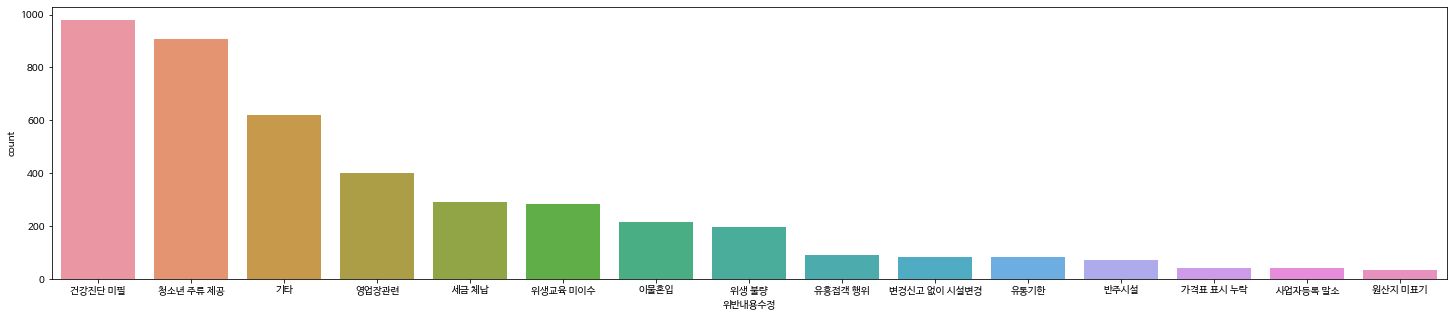

In [41]:
plt.rcParams["figure.figsize"] = (25, 5)
fig = sns.countplot(x ='위반내용수정', data = dfRegular, order = dfRegular['위반내용수정'].value_counts().index)

In [ ]:
plt.rcParams["figure.figsize"] = (25, 5)
fig = sns.countplot(x ='처분명수정', data = dfRegular, order = dfRegular['처분명수정'].value_counts().index)

In [150]:
#plotly와 dash이용

import dash
from dash import dcc
from dash import html
from dash.dependencies import Input, Output
from jupyter_dash import JupyterDash

import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

In [161]:
#line test

data_dates = dfRegular['처분일자'].value_counts()
dates = data_dates.to_frame(name='위반횟수')
dates.index.name = '처분일자'
dates = dates.resample('M').sum()

fig = go.Figure(data=[go.Scatter(x=dates.index, y=dates['위반횟수'])])

#fig = px.line(x=dates.index, y=dates['위반횟수'])
#fig = px.line(x=dates.index, y=dates.위반횟수)

fig.show()

In [210]:
#pie test

dfRegula_count = dfRegular.groupby(by=['업태명'], as_index=False).count()
frequency = dfRegula_count['Year'];
label = dfRegula_count['업태명'];

fig = go.Figure(data=[go.Pie(labels=label, values=frequency)])
fig.update_traces(textposition='inside')

fig.show()

In [191]:
#bar test

data_dates = dfRegular['처분명수정'].value_counts()
dates = data_dates.to_frame(name='처분명수정')
#dates.index.name = '처분명수정'

#bar color -> https://stackoverflow.com/questions/61892036/plotly-how-to-colorcode-plotly-graph-objects-bar-chart-using-python
k=[15,30,45,60,75,90]
fig = go.Figure(data=[go.Bar(x=dates.index, y=dates['처분명수정'],
                             marker=dict(color = k, colorscale='viridis'))])

fig.show()

전반적인 분석



In [207]:
#참고 자료(공식)
#plotly express -> https://plotly.com/python/plotly-express/
#plotly subplot -> https://plotly.com/python/subplots/#multiple-subplots
#plotly line&scatter -> https://plotly.com/python/line-and-scatter/
#plotly piechart -> https://plotly.com/python/pie-charts/

#참고 자료(그외)
#https://tariat.tistory.com/749

#line, pie 들어갈 수 있게 1X2의 figure생성
# specs로 들어갈 차트 종류 설정줘야 함! -> https://stackoverflow.com/questions/54975791/how-to-subplot-pie-chart-in-plotly
fig = make_subplots(rows=2, cols=2, specs=[[{'type':'scatter'}, {'type': 'pie', 'rowspan':2}], [{'type':'bar'}, None]],column_widths=[0.7, 0.3],
                    subplot_titles=("년도별 분석","업태별 분석", "처분명 분석"))


#line 데이터 정리
data_dates = dfRegular['처분일자'].value_counts()
dates = data_dates.to_frame(name='위반횟수')
dates.index.name = '처분일자'
dates.sort_values(by=['처분일자'])
dates = dates.resample('M').sum()

#line 그래프 그려줌
fig.add_trace(go.Scatter(x=dates.index, y=dates['위반횟수']),
              row=1, col=1)

#line 그래프 x, y축 타이틀 설정
#설정방법 -> https://stackoverflow.com/questions/65779052/how-to-set-axis-label-in-subplots-with-dash/65779105
fig.update_xaxes(title_text="날짜", row=1, col=1)
fig.update_yaxes(title_text="횟수", row=1, col=1)

#pie 데이터 정리
dfRegula_count = dfRegular.groupby(by=['업태명'], as_index=False).count()
frequency = dfRegula_count['Year'];
label = dfRegula_count['업태명'];

#pie 그래프 그려줌
fig.add_trace(go.Pie(labels=label, values=frequency, ),
              row=1, col=2)
fig.update_traces(textposition='inside', row=1, col=2)

#bar 데이터 정리
data_dates = dfRegular['처분명수정'].value_counts()
dates = data_dates.to_frame(name='처분명수정')

#bar 그래프 그려줌
k=[15,30,45,60,75,90]
fig.add_trace(go.Bar(x=dates.index, y=dates['처분명수정'],
                             marker=dict(color = k, colorscale='viridis')),
              row=2, col=1)

fig.show()

In [148]:
#위반 내용별 분석을 위해, '기타'제외한 위반내용 뽑아옴

available_in = dfRegular['위반내용수정'].unique()
available_in = np.delete(available_in, np.where( available_in == '기타'))
available_in

array(['청소년 주류 제공', '영업장관련', '이물혼입', '유통기한', '위생 불량', '건강진단 미필',
       '유흥접객 행위', '세금 체납', '변경신고 없이 시설변경', '위생교육 미이수', '사업자등록 말소',
       '가격표 표시 누락', '원산지 미표기', '반주시설'], dtype=object)

In [211]:
# 참고자료
#4주차 과제 마지막 Dash
#https://medium.com/plotly/introducing-dash-5ecf7191b503
#위 링크 안 소스코드 -> https://gist.github.com/chriddyp/9b2b3e8a6c67697279d3724dce5dab3c

#전체분석과 같은 툴로 대시보드 생성

app = JupyterDash()

app.layout = html.Div(id = 'parent',
    children = [html.H1(id='title', children = '위반 종류별 분석',
                            style = {'textAlign':'center', 'marginTop' : 40, 'marginBottom':40}),

                    dcc.Dropdown(id='dropdown',
                                   options = [{'label':i, 'value':i} for i in available_in],                                              
                                   value='전체'),
                    dcc.Graph(id = 'plot')
      ])

@app.callback(Output(component_id='plot', component_property= 'figure'),
              [Input(component_id='dropdown', component_property= 'value')])

def graph_update(dropdown_value):
  dfRegular_contents = dfRegular[dfRegular.위반내용수정==dropdown_value]

  fig = make_subplots(rows=2, cols=2, specs=[[{'type':'scatter'}, {'type': 'pie', 'rowspan':2}], [{'type':'bar'}, None]],column_widths=[0.7, 0.3],
                      subplot_titles=("년도별 분석","업태별 분석", "처분명 분석"))


  #line 데이터 정리
  data_dates = dfRegular_contents['처분일자'].value_counts()
  dates = data_dates.to_frame(name='위반횟수')
  dates.index.name = '처분일자'
  dates.sort_values(by=['처분일자'])
  dates = dates.resample('M').sum()

  #line 그래프 그려줌
  fig.add_trace(go.Scatter(x=dates.index, y=dates['위반횟수']),
                row=1, col=1)

  #line 그래프 x, y축 타이틀 설정
  fig.update_xaxes(title_text="날짜", row=1, col=1)
  fig.update_yaxes(title_text="횟수", row=1, col=1)

  #pie 데이터 정리
  dfRegula_count = dfRegular_contents.groupby(by=['업태명'], as_index=False).count()
  frequency = dfRegula_count['Year'];
  label = dfRegula_count['업태명'];

  #pie 그래프 그려줌
  fig.add_trace(go.Pie(labels=label, values=frequency, ),
                row=1, col=2)
  fig.update_traces(textposition='inside', row=1, col=2)

  #bar 데이터 정리
  data_dates = dfRegular_contents['처분명수정'].value_counts()
  dates = data_dates.to_frame(name='처분명수정')

  #bar 그래프 그려줌
  k=[15,30,45,60,75,90]
  fig.add_trace(go.Bar(x=dates.index, y=dates['처분명수정'],
                               marker=dict(color = k, colorscale='viridis')),
                row=2, col=1)
  
  return fig 

if __name__ == '__main__': 
    app.run_server()

Dash app running on:


<IPython.core.display.Javascript object>